# NASA Turbofan Jet Engine - EDA (Exploratory Data Analysis)

## 프로젝트 개요
- **목표**: NASA 터보팬 제트 엔진의 잔존 수명(RUL) 예측 및 예지보전 방안 모색
- **데이터**: NASA C-MAPSS (Commercial Modular Aero-Propulsion System Simulation) 데이터셋

## EDA 구조
1. 데이터 불러오기
2. 전체 사이클 분포 분석
3. 센서별 드리프트/패턴 분석
4. 제거할 센서 리스트 확정
5. Rolling window 길이 확정

## 1. 라이브러리 Import 및 초기 설정

In [2]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# 시각화 설정
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (macOS)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False


In [ ]:
import pandas as pd
from pathlib import Path

raw_path = Path('../CMaps/train_FD001.txt')
save_path = Path('../CMaps/Data/train_FD001.csv')

column_names = [
    'unit_id', 'time_cycles',
    'op_setting_1', 'op_setting_2', 'op_setting_3',
    'T2', 'T24', 'T30', 'T50',
    'P2', 'P15', 'P30',
    'Nf', 'Nc',
    'epr', 'Ps30', 'phi',
    'NRf', 'NRc',
    'BPR', 'farB', 'htBleed',
    'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32'
]


df = pd.read_csv(raw_path, sep='\s+', header=None, names=column_names)
df.to_csv(save_path, index=False)

In [ ]:
import pandas as pd
from pathlib import Path

raw_path = Path('../CMaps/test_FD001.txt')
save_path = Path('../CMaps/Data/test_FD001.csv')

column_names = [
    'unit_id', 'time_cycles',
    'op_setting_1', 'op_setting_2', 'op_setting_3',
    'T2', 'T24', 'T30', 'T50',
    'P2', 'P15', 'P30',
    'Nf', 'Nc',
    'epr', 'Ps30', 'phi',
    'NRf', 'NRc',
    'BPR', 'farB', 'htBleed',
    'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32'
]


df = pd.read_csv(raw_path, sep='\s+', header=None, names=column_names)
df.to_csv(save_path, index=False)

## 2. 데이터 불러오기

데이터 구조:
- **26개 컬럼**: unit number(1) + time(1) + operational settings(3) + sensor measurements(21)
- **FD001**: 100개 train, 100개 test (조건: 1개, 고장모드: HPC Degradation)

In [5]:
# 데이터 경로 설정
data_path = Path('../CMaps/Data')

train_df = pd.read_csv(data_path / 'train_FD001.csv')
test_df = pd.read_csv(data_path / 'test_FD001.csv') 

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit_id       20631 non-null  int64  
 1   time_cycles   20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   T2            20631 non-null  float64
 6   T24           20631 non-null  float64
 7   T30           20631 non-null  float64
 8   T50           20631 non-null  float64
 9   P2            20631 non-null  float64
 10  P15           20631 non-null  float64
 11  P30           20631 non-null  float64
 12  Nf            20631 non-null  float64
 13  Nc            20631 non-null  float64
 14  epr           20631 non-null  float64
 15  Ps30          20631 non-null  float64
 16  phi           20631 non-null  float64
 17  NRf           20631 non-null  float64
 18  NRc           20631 non-nu

In [8]:
train_df.head()

,unit_id,time_cycles,op_setting_1,op_setting_2,op_setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [9]:
train_df.describe()

,unit_id,time_cycles,op_setting_1,op_setting_2,op_setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   unit_id       13096 non-null  int64  
 1   time_cycles   13096 non-null  int64  
 2   op_setting_1  13096 non-null  float64
 3   op_setting_2  13096 non-null  float64
 4   op_setting_3  13096 non-null  float64
 5   T2            13096 non-null  float64
 6   T24           13096 non-null  float64
 7   T30           13096 non-null  float64
 8   T50           13096 non-null  float64
 9   P2            13096 non-null  float64
 10  P15           13096 non-null  float64
 11  P30           13096 non-null  float64
 12  Nf            13096 non-null  float64
 13  Nc            13096 non-null  float64
 14  epr           13096 non-null  float64
 15  Ps30          13096 non-null  float64
 16  phi           13096 non-null  float64
 17  NRf           13096 non-null  float64
 18  NRc           13096 non-nu

In [11]:
test_df.head()

,unit_id,time_cycles,op_setting_1,op_setting_2,op_setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [13]:
test_df.describe()

,unit_id,time_cycles,op_setting_1,op_setting_2,op_setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.0,13096.00,13096.000000,13096.000000,13096.000000,1.309600e+04,...,13096.000000,13096.000000,13096.000000,13096.000000,1.309600e+04,13096.000000,13096.0,13096.0,13096.000000,13096.000000
mean,51.543907,76.836515,-0.000011,0.000004,100.0,518.67,642.475088,1588.099204,1404.735362,1.462000e+01,...,521.747724,2388.071025,8138.947817,8.425844,3.000000e-02,392.571625,2388.0,100.0,38.892502,23.335743
std,28.289423,53.057749,0.002203,0.000294,0.0,0.00,0.400899,5.003274,6.688309,1.776425e-15,...,0.559627,0.056934,10.188605,0.029009,1.040874e-17,1.233577,0.0,0.0,0.141681,0.084120
min,1.000000,1.000000,-0.008200,-0.000600,100.0,518.67,641.130000,1569.040000,1384.390000,1.462000e+01,...,519.380000,2387.890000,8108.500000,8.332800,3.000000e-02,389.000000,2388.0,100.0,38.310000,22.935400
25%,28.000000,33.000000,-0.001500,-0.000200,100.0,518.67,642.197500,1584.600000,1399.950000,1.462000e+01,...,521.380000,2388.030000,8132.310000,8.405600,3.000000e-02,392.000000,2388.0,100.0,38.800000,23.281600
50%,52.000000,69.000000,-0.000000,-0.000000,100.0,518.67,642.460000,1587.990000,1404.440000,1.462000e+01,...,521.780000,2388.070000,8138.390000,8.424900,3.000000e-02,393.000000,2388.0,100.0,38.900000,23.339200
75%,76.000000,113.000000,0.001500,0.000300,100.0,518.67,642.740000,1591.362500,1409.050000,1.462000e+01,...,522.150000,2388.110000,8144.360000,8.444300,3.000000e-02,393.000000,2388.0,100.0,38.990000,23.393600
max,100.000000,303.000000,0.007800,0.000700,100.0,518.67,644.300000,1607.550000,1433.360000,1.462000e+01,...,523.760000,2388.320000,8220.480000,8.541400,3.000000e-02,397.000000,2388.0,100.0,39.410000,23.641900


## 환경 조건 변수 분포 및 해석

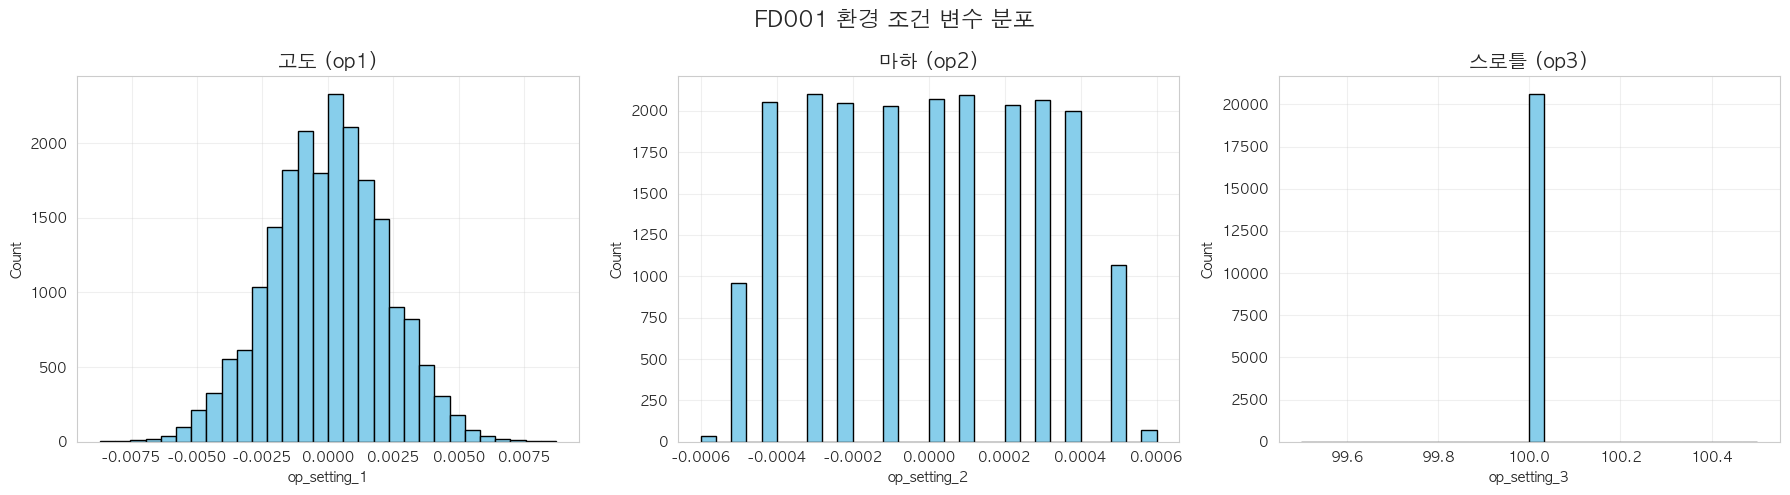

In [14]:
# 환경 조건 변수 분포 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
env_vars = ['op_setting_1', 'op_setting_2', 'op_setting_3']
titles = ['고도 (op1)', '마하 (op2)', '스로틀 (op3)']
for i, var in enumerate(env_vars):
    axes[i].hist(train_df[var], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(titles[i], fontsize=14)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')
    axes[i].grid(alpha=0.3)
plt.suptitle('FD001 환경 조건 변수 분포', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

- op1(고도) : 정규분포  
0을 중심으로 정규분포의 형태를 가짐.  
특정 설정값을 기준으로 약간의 노이즈나 변동성만 갖는 연속형 변수를 의미  
--- 
- op2(마하) : 여러 가지 그룹  
여러 개의 뚜렷한 값으로 나뉘며, 범주형, 원-핫 인코딩 등  
여러가지 전처리 적용 방안을 세울 수 있음.  
---
- op3(스로틀) : 상수  
100.0의 단일값을 가지는 추력 조건  
분산이 0을 나타내는 변수이며, RUL 예측에 대한 정보를 제공하지 못함.  
---
FD001 데이터셋은 단일 조건으로  위 분포는 단일 운전 조건 하에서의 
미세한 변동(noise).


## 3. 전체 사이클 분포 분석

각 엔진의 전체 수명 사이클 수를 파악하고, RUL을 계산합니다.

In [15]:
# 각 엔진별 전체 사이클 수 계산
train_max_cycles = train_df.groupby('unit_id')['time_cycles'].max().reset_index()
train_max_cycles.columns = ['unit_id', 'max_cycles']

print("엔진별 전체 사이클 수 통계:")
print(train_max_cycles['max_cycles'].describe())
print(f"\n총 엔진 수: {train_max_cycles['unit_id'].nunique()}개")
print(f"평균 수명: {train_max_cycles['max_cycles'].mean():.2f} cycles")
print(f"최소 수명: {train_max_cycles['max_cycles'].min()} cycles")
print(f"최대 수명: {train_max_cycles['max_cycles'].max()} cycles")

엔진별 전체 사이클 수 통계:
count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: max_cycles, dtype: float64

총 엔진 수: 100개
평균 수명: 206.31 cycles
최소 수명: 128 cycles
최대 수명: 362 cycles


<FD001_unit1>

In [23]:
sensor_cols = ['T2', 'T24', 'T30', 'T50',
    'P2', 'P15', 'P30',
    'Nf', 'Nc',
    'epr', 'Ps30', 'phi',
    'NRf', 'NRc',
    'BPR', 'farB', 'htBleed',
    'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']

sensor_stats = train_df[sensor_cols].agg(['mean', 'std', 'min', 'max']).T

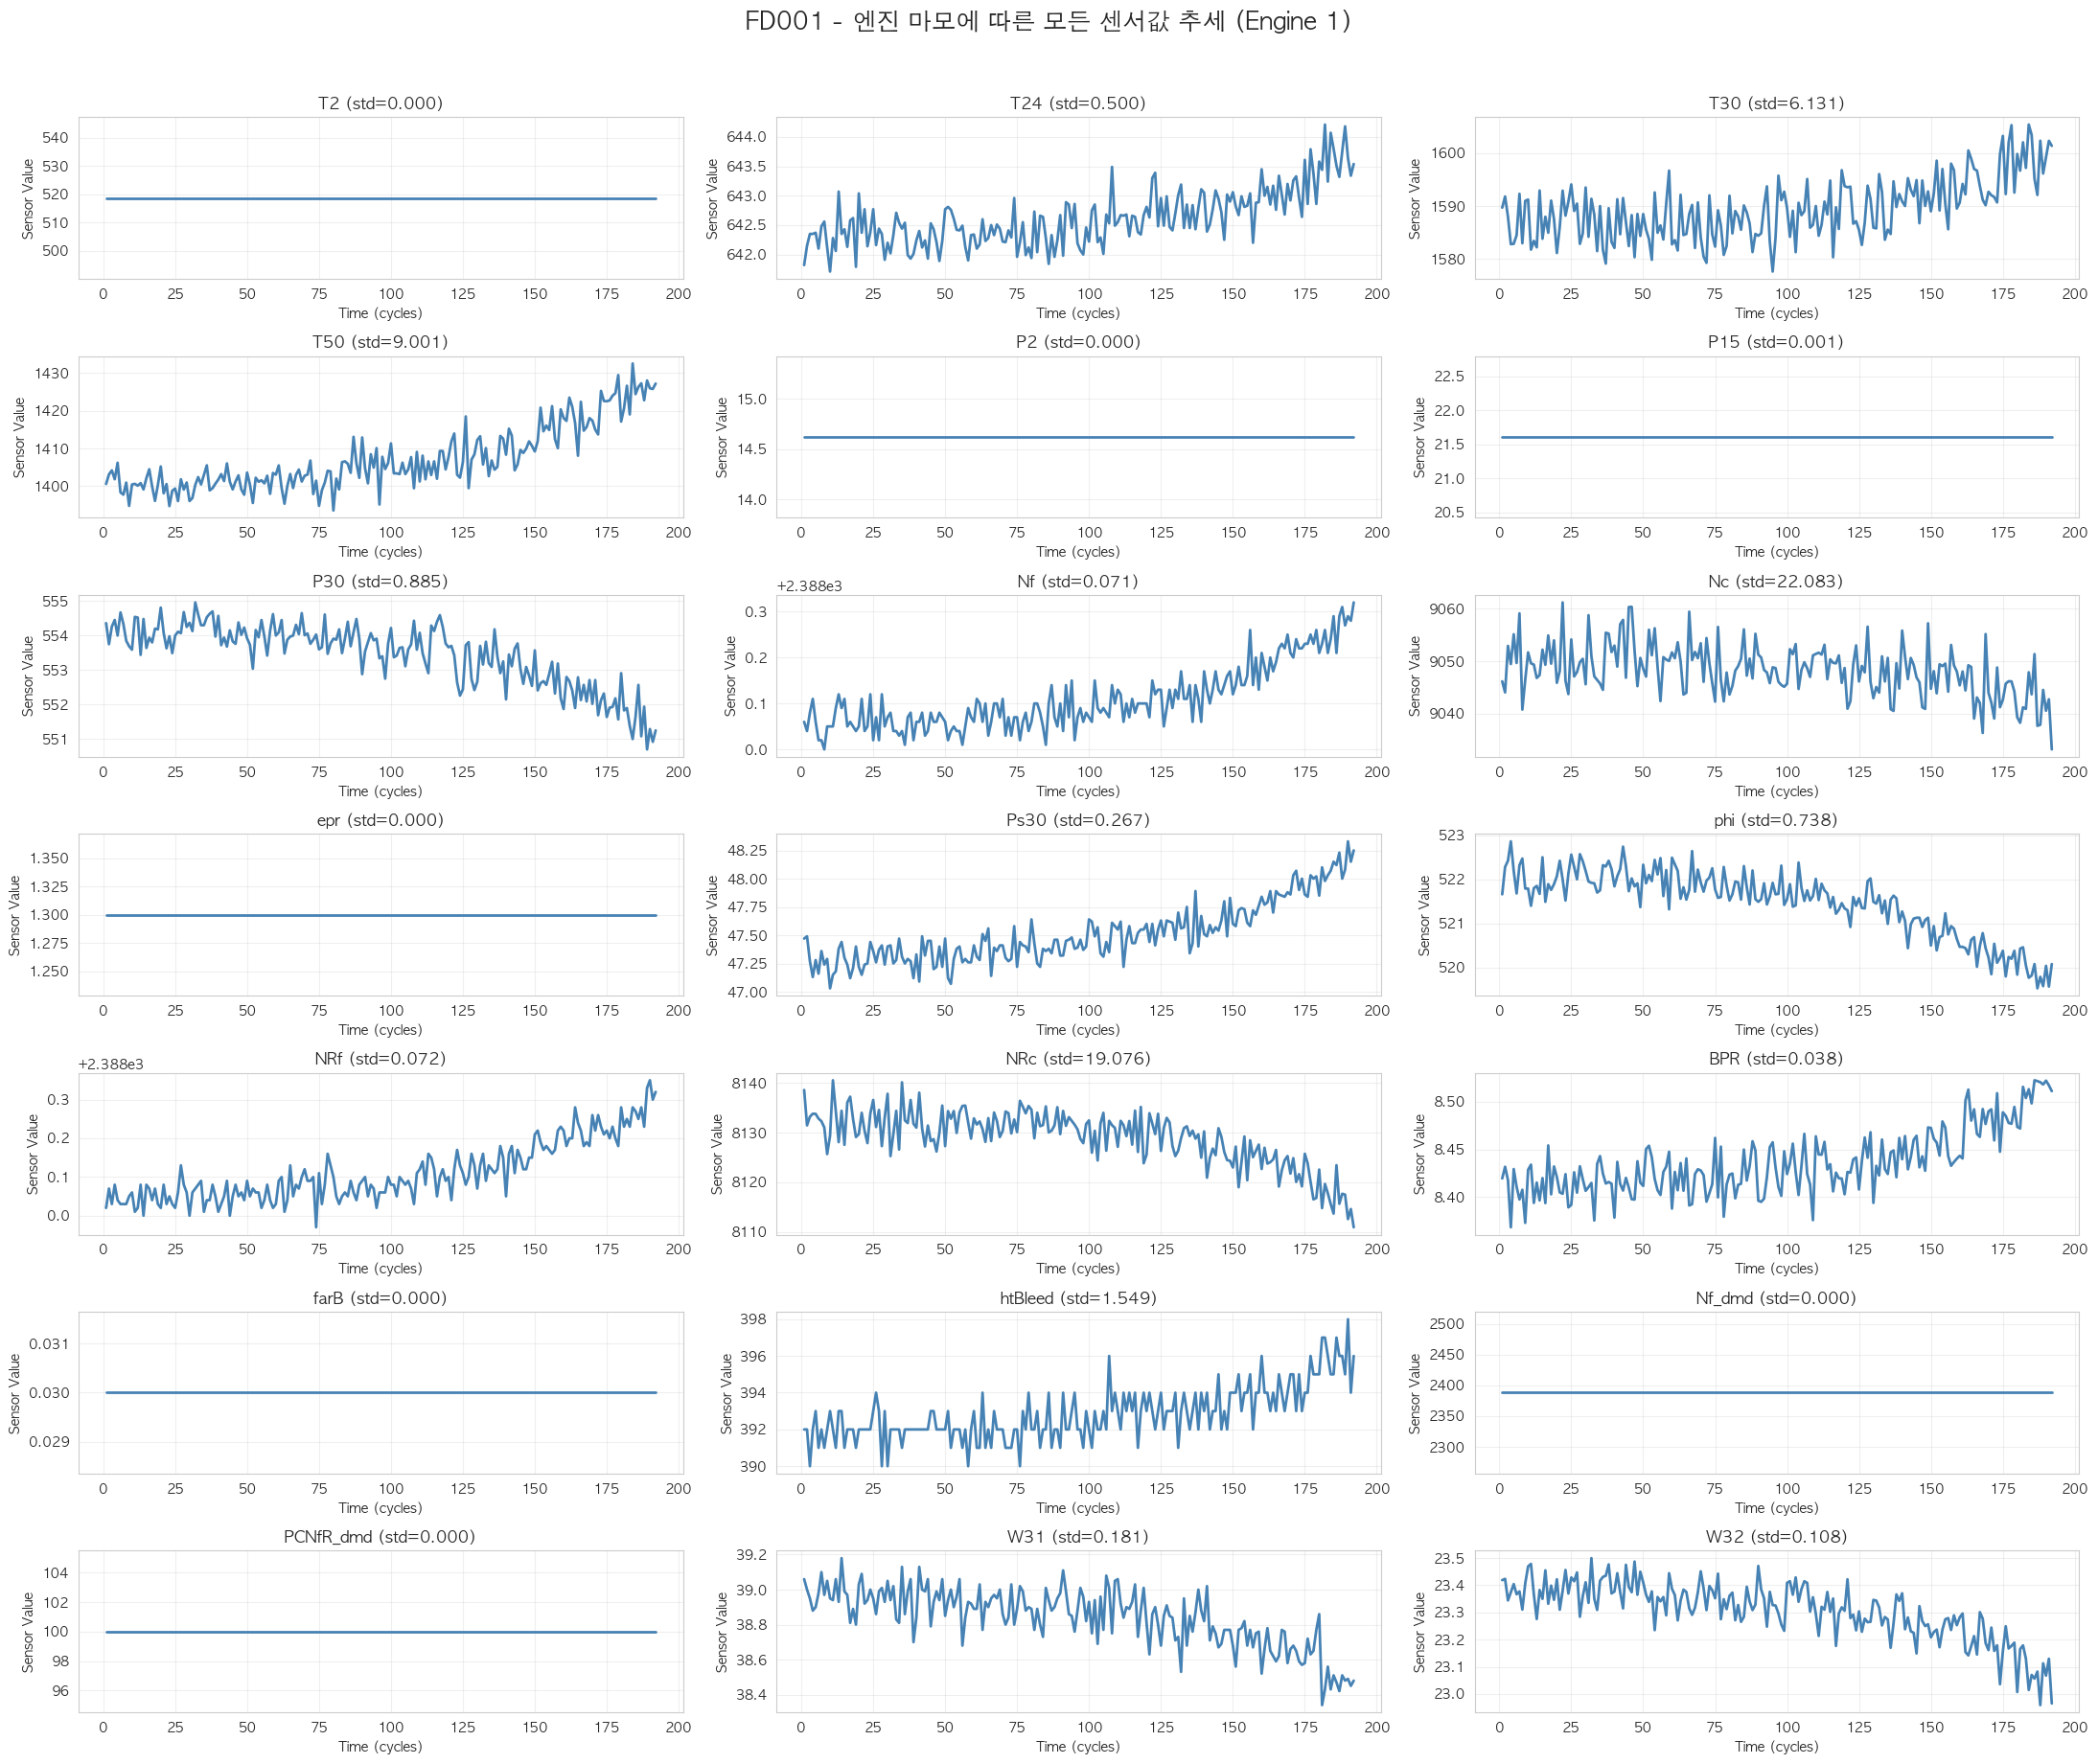

In [24]:
# 엔진 마모(사이클 진행)에 따른 모든 센서값 추세 시각화 (Engine 1, 21개 센서)
sample_engine = train_df[train_df['unit_id'] == 1].copy()
all_sensors = sensor_cols  # 21개 센서 모두
fig, axes = plt.subplots(7, 3, figsize=(22, 18))
axes = axes.ravel()
for idx, sensor in enumerate(all_sensors):
    axes[idx].plot(sample_engine['time_cycles'], sample_engine[sensor], color='steelblue', linewidth=2)
    axes[idx].set_title(f'{sensor} (std={sensor_stats.loc[sensor, "std"]:.3f})', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time (cycles)', fontsize=10)
    axes[idx].set_ylabel('Sensor Value', fontsize=10)
    axes[idx].grid(alpha=0.3)
# 빈 서브플롯 숨기기 (21개 이후)
for idx in range(len(all_sensors), len(axes)):
    axes[idx].axis('off')
plt.suptitle('FD001 - 엔진 마모에 따른 모든 센서값 추세 (Engine 1)', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

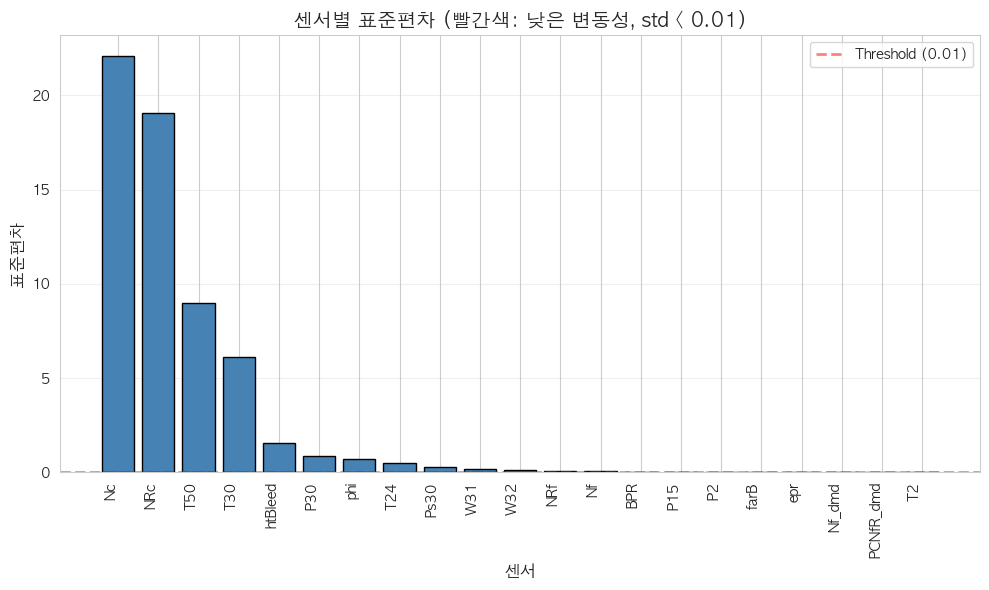

In [34]:
# 센서별 표준편차 시각화
fig, ax = plt.subplots(figsize=(10, 6))

sensor_stats_sorted = sensor_stats.sort_values('std', ascending=False)
colors = ['red' if x < 0.01 else 'steelblue' for x in sensor_stats_sorted['std']]

ax.bar(range(len(sensor_stats_sorted)), sensor_stats_sorted['std'], color=colors, edgecolor='black')
ax.set_xticks(range(len(sensor_stats_sorted)))
ax.set_xticklabels(sensor_stats_sorted.index, rotation=90, ha='right')
ax.set_xlabel('센서', fontsize=12)
ax.set_ylabel('표준편차', fontsize=12)
ax.set_title('센서별 표준편차 (빨간색: 낮은 변동성, std < 0.01)', fontsize=14, fontweight='bold')
ax.axhline(y=0.01, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Threshold (0.01)')
ax.legend()
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

Nc(코어 속도), NRc(보정 속도)는 높은 표준편차를 보임     
T30(고압 압축기 출구 온도, HPC), T50(저압 터빈 출구 온도 LPT) 또한 변동이 존재함  

### RUL 적용

In [ ]:
train_df['max_cycle'] = train_df.groupby('unit_id')['time_cycles'].transform('max')
train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']
train_df.drop(columns='max_cycle', inplace=True)

train_df.to_csv('../CMaps/Data/train_FD001_with_RUL.csv', index=False)

In [37]:

rul_df = pd.read_csv('../CMaps/RUL_FD001.txt', header=None, names=['RUL'])

last_cycle_idx = test_df.groupby('unit_id')['time_cycles'].idxmax()
test_df['RUL'] = None 
test_df.loc[last_cycle_idx, 'RUL'] = rul_df['RUL'].values

test_df.to_csv('../CMaps/Data/test_FD001_with_RUL.csv', index=False)

### 센서값(T30, T50, Nc, NRc)의 사이클별 시계열 변화

In [40]:
sensor_cols = ['T30', 'T50', 'Nc', 'NRc']

rul_by_unit = train_df.groupby('unit_id')['RUL'].first()  # 학습셋은 RUL = max_cycle - t

# RUL 상위 3개, 하위 3개
top_units = rul_by_unit.sort_values(ascending=False).head(3).index.tolist()
bottom_units = rul_by_unit.sort_values(ascending=True).head(3).index.tolist()

print("RUL 상위 3 Unit:", top_units)
print("RUL 하위 3 Unit:", bottom_units)

RUL 상위 3 Unit: [69, 92, 96]
RUL 하위 3 Unit: [39, 91, 70]


In [44]:
def plot_sensor_trends(df, units, sensors, title):
    fig, axes = plt.subplots(1, len(sensors), figsize=(5 * len(sensors), 4), dpi=120)
    if len(sensors) == 1:
        axes = [axes]

    colors = plt.get_cmap('tab10').colors  # 다양한 색상

    for i, sensor in enumerate(sensors):
        for j, uid in enumerate(units):
            unit_df = df[df['unit_id'] == uid]
            axes[i].plot(unit_df['time_cycles'], unit_df[sensor],
                         label=f'Unit {uid}',
                         color=colors[j % len(colors)],
                         linewidth=2)
        axes[i].set_title(f'{sensor} over Cycles', fontsize=12)
        axes[i].set_xlabel('Cycle')
        axes[i].set_ylabel(sensor)
        axes[i].grid(alpha=0.3)
        axes[i].legend(fontsize=9)

    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

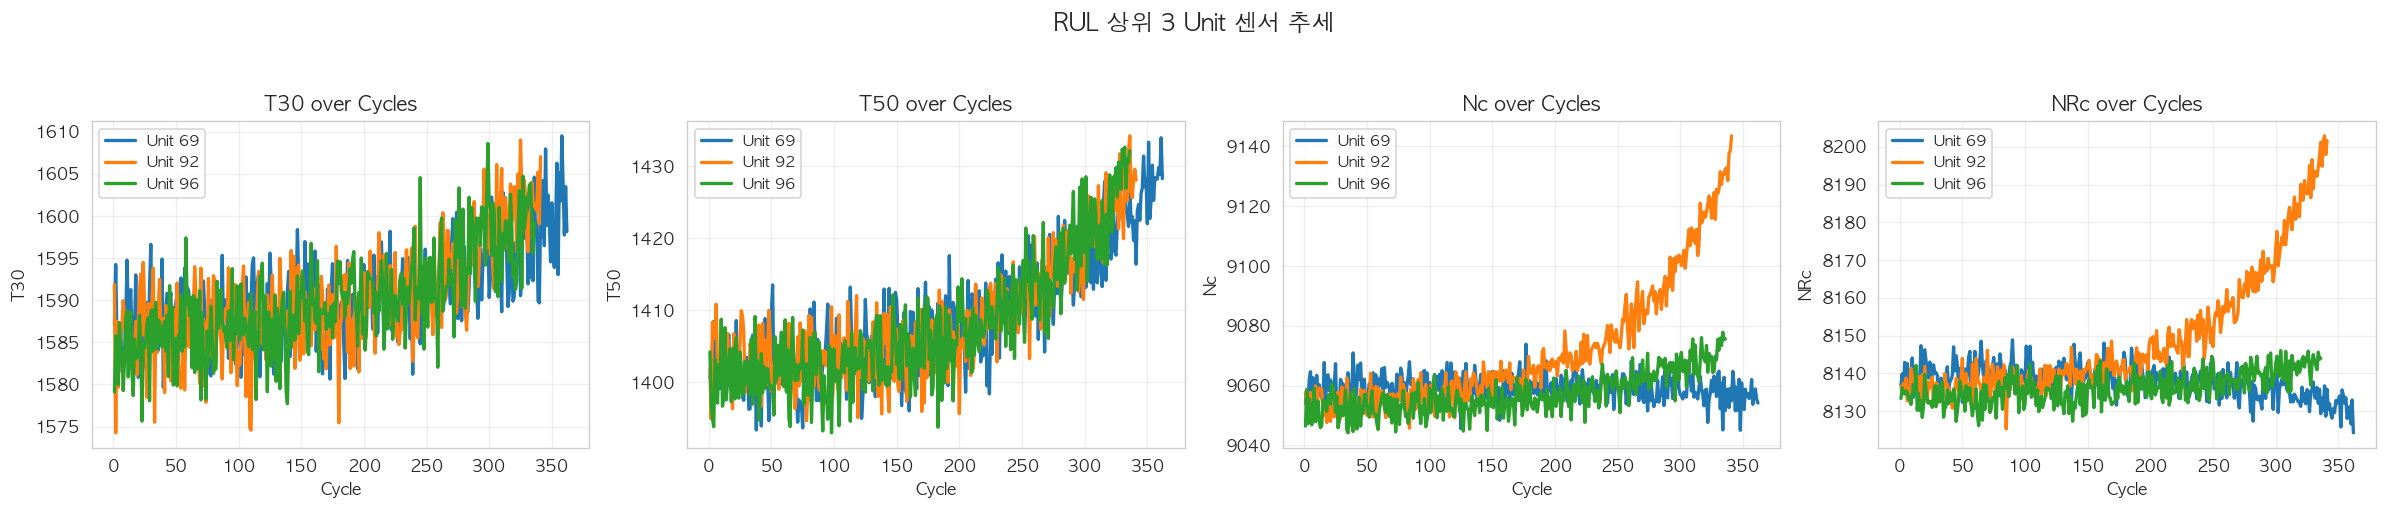

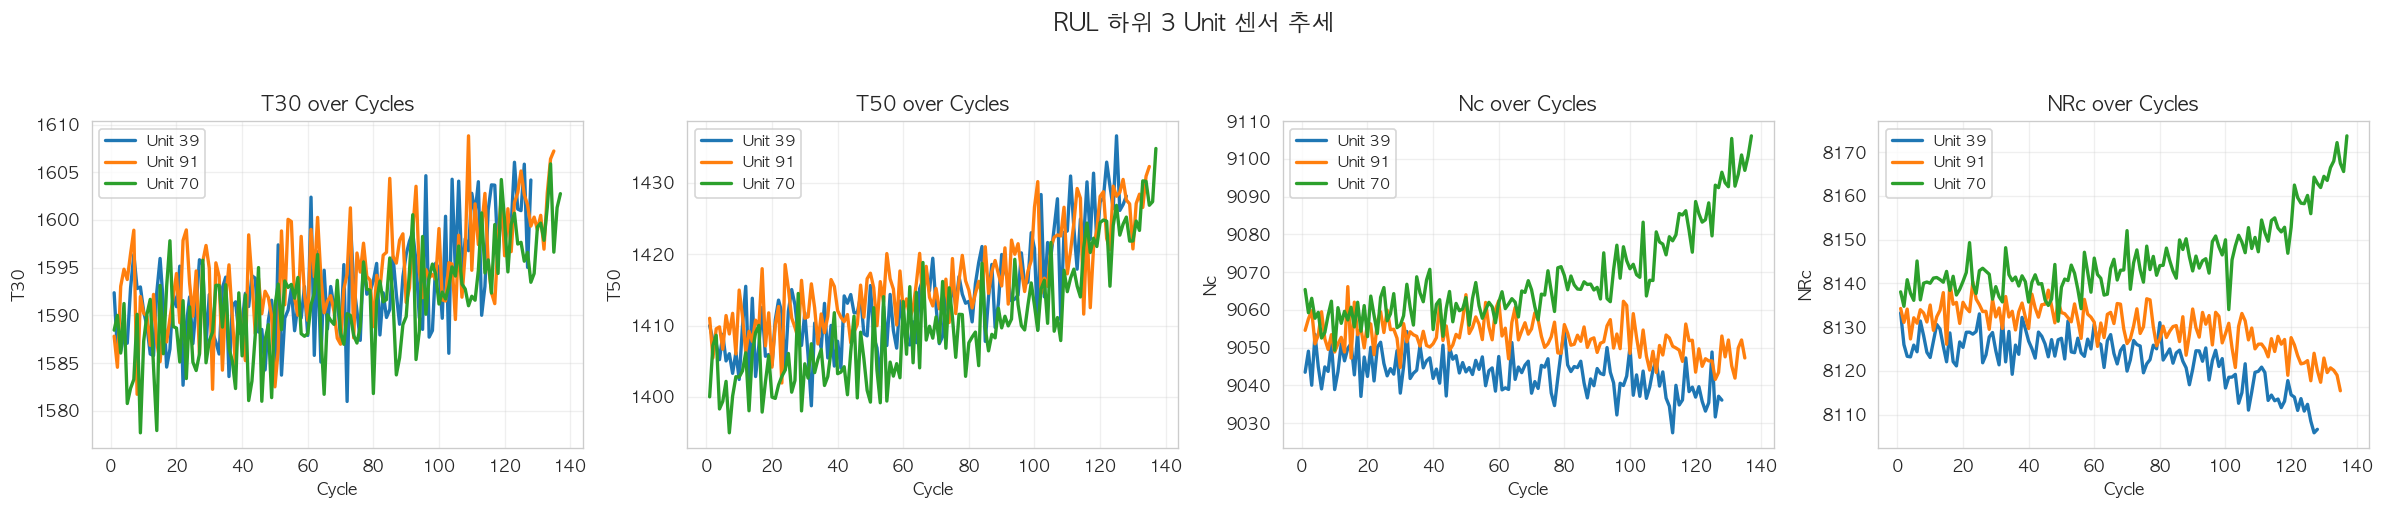

In [45]:
plot_sensor_trends(train_df, top_units, sensor_cols, 'RUL 상위 3 Unit 센서 추세')
plot_sensor_trends(train_df, bottom_units, sensor_cols, 'RUL 하위 3 Unit 센서 추세')

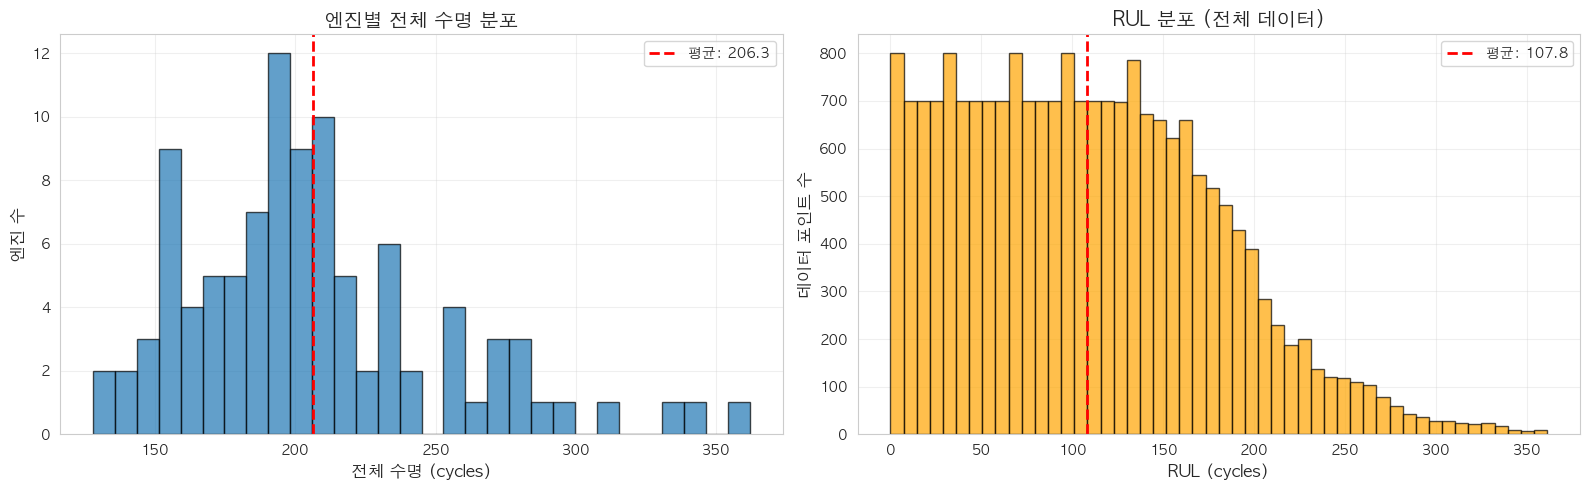

In [39]:
# 사이클 수 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# 1. 엔진별 전체 사이클 수 히스토그램
axes[0].hist(train_max_cycles['max_cycles'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(train_max_cycles['max_cycles'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"평균: {train_max_cycles['max_cycles'].mean():.1f}")
axes[0].set_xlabel('전체 수명 (cycles)', fontsize=12)
axes[0].set_ylabel('엔진 수', fontsize=12)
axes[0].set_title('엔진별 전체 수명 분포', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. RUL 분포
axes[1].hist(train_df['RUL'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(train_df['RUL'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f"평균: {train_df['RUL'].mean():.1f}")
axes[1].set_xlabel('RUL (cycles)', fontsize=12)
axes[1].set_ylabel('데이터 포인트 수', fontsize=12)
axes[1].set_title('RUL 분포 (전체 데이터)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. 센서별 드리프트/패턴 분석

21개 센서 데이터의 특성을 분석합니다:
- 시간에 따른 변화 패턴
- 분산 및 변동성
- RUL과의 상관관계

In [102]:
# 센서 데이터 분산 분석
sensor_stats = pd.DataFrame()
sensor_stats['std'] = train_df[sensor_cols].std()
sensor_stats['variance'] = train_df[sensor_cols].var()
sensor_stats['mean'] = train_df[sensor_cols].mean()
sensor_stats['min'] = train_df[sensor_cols].min()
sensor_stats['max'] = train_df[sensor_cols].max()
sensor_stats['range'] = sensor_stats['max'] - sensor_stats['min']

# 변동성이 거의 없는 센서 식별 (표준편차 < 0.01)
low_variance_sensors = sensor_stats[sensor_stats['std'] < 0.01].index.tolist()

print("센서별 통계:")
print(sensor_stats.sort_values('std', ascending=False))


센서별 통계:
                    std      variance         mean        min        max  \
Nc         2.208288e+01  4.876536e+02  9065.242941  9021.7300  9244.5900   
NRc        1.907618e+01  3.639005e+02  8143.752722  8099.9400  8293.7200   
T50        9.000605e+00  8.101089e+01  1408.933782  1382.2500  1441.4900   
T30        6.131150e+00  3.759099e+01  1590.523119  1571.0400  1616.9100   
htBleed    1.548763e+00  2.398667e+00   393.210654   388.0000   400.0000   
P30        8.850923e-01  7.833883e-01   553.367711   549.8500   556.0600   
phi        7.375534e-01  5.439850e-01   521.413470   518.6900   523.3800   
T24        5.000533e-01  2.500533e-01   642.680934   641.2100   644.5300   
Ps30       2.670874e-01  7.133568e-02    47.541168    46.8500    48.5300   
W31        1.807464e-01  3.266927e-02    38.816271    38.1400    39.4300   
W32        1.082509e-01  1.171825e-02    23.289705    22.8942    23.6184   
NRf        7.191892e-02  5.172330e-03  2388.096152  2387.8800  2388.5600   
Nf  

RUL과의 상관계수 (절대값 기준 상위 10개):
Ps30       0.696228
T50        0.678948
phi        0.671983
P30        0.657223
BPR        0.642667
W32        0.635662
W31        0.629428
T24        0.606484
htBleed    0.606154
T30        0.584520
Name: RUL, dtype: float64


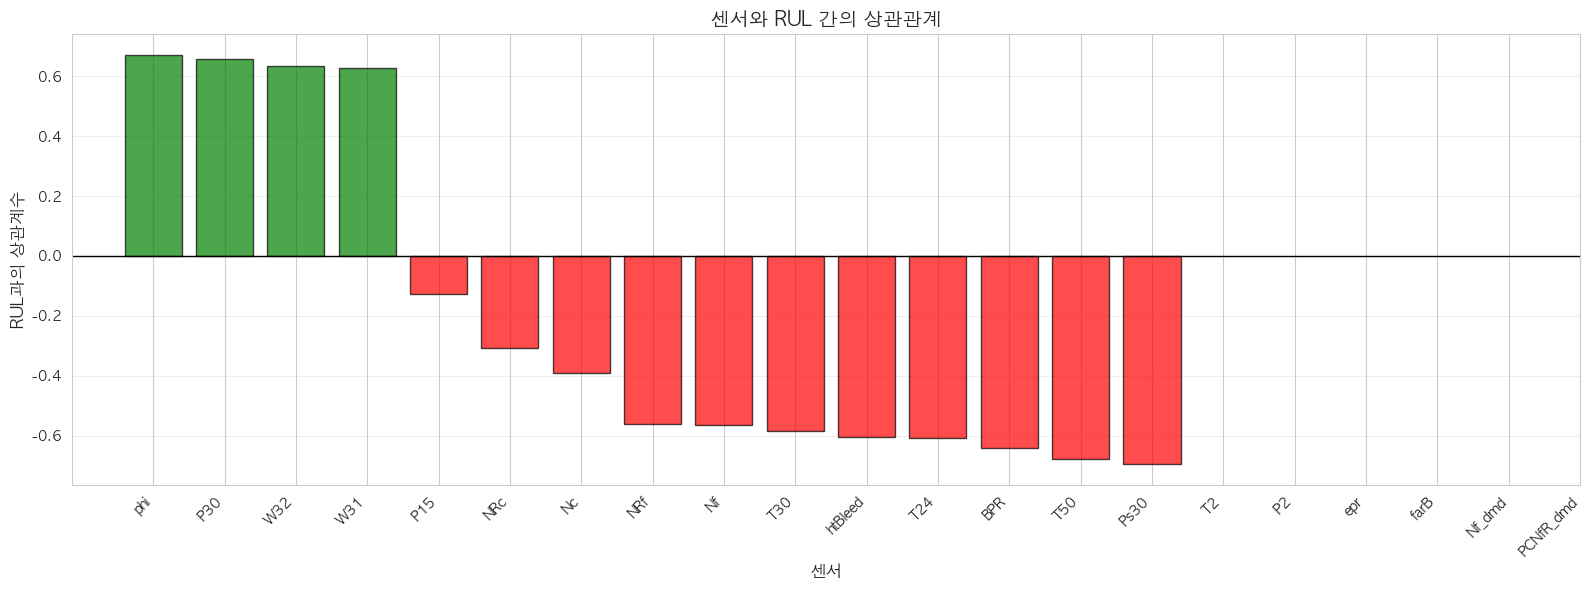

In [106]:
# RUL과 센서 간의 상관관계 분석
correlation_with_rul = train_df[sensor_cols + ['RUL']].corr()['RUL'].drop('RUL').sort_values(ascending=False)

print("RUL과의 상관계수 (절대값 기준 상위 10개):")
print(correlation_with_rul.abs().sort_values(ascending=False).head(10))

# 상관계수 시각화
fig, ax = plt.subplots(figsize=(16, 6))

colors = ['green' if x > 0 else 'red' for x in correlation_with_rul.values]
ax.bar(range(len(correlation_with_rul)), correlation_with_rul.values, 
       color=colors, edgecolor='black', alpha=0.7)
ax.set_xticks(range(len(correlation_with_rul)))
ax.set_xticklabels(correlation_with_rul.index, rotation=45, ha='right')
ax.set_xlabel('센서', fontsize=12)
ax.set_ylabel('RUL과의 상관계수', fontsize=12)
ax.set_title('센서와 RUL 간의 상관관계', fontsize=14, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [107]:
# 제거할 센서 식별
std_threshold = 0.01
corr_threshold = 0.1

# 1. 낮은 변동성 센서
low_variance = sensor_stats[sensor_stats['std'] < std_threshold].index.tolist()

# 2. 낮은 상관성 센서
low_correlation = correlation_with_rul[abs(correlation_with_rul) < corr_threshold].index.tolist()

# 합집합 (둘 중 하나라도 해당되면 제거 후보)
sensors_to_remove = list(set(low_variance + low_correlation))
sensors_to_remove.sort()

# 유지할 센서
sensors_to_keep = [s for s in sensor_cols if s not in sensors_to_remove]

print("=" * 60)
print("센서 제거 분석 결과")
print("=" * 60)
print(f"\n1. 낮은 변동성 센서 (std < {std_threshold}):")
print(f"   {low_variance}")
print(f"\n2. 낮은 상관성 센서 (|corr| < {corr_threshold}):")
print(f"   {low_correlation}")
print(f"\n제거할 센서 (총 {len(sensors_to_remove)}개):")
print(f"   {sensors_to_remove}")
print(f"\n유지할 센서 (총 {len(sensors_to_keep)}개):")
print(f"   {sensors_to_keep}")

# 제거 상세 정보
print("\n" + "=" * 60)
print("제거 센서 상세 정보")
print("=" * 60)
removal_info = pd.DataFrame({
    'sensor': sensors_to_remove,
    'std': [sensor_stats.loc[s, 'std'] for s in sensors_to_remove],
    'corr_with_RUL': [correlation_with_rul.loc[s] for s in sensors_to_remove],
    'reason': ['Low Variance' if s in low_variance else 'Low Correlation' 
               for s in sensors_to_remove]
})
print(removal_info.to_string(index=False))

센서 제거 분석 결과

1. 낮은 변동성 센서 (std < 0.01):
   ['T2', 'P2', 'P15', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd']

2. 낮은 상관성 센서 (|corr| < 0.1):
   []

제거할 센서 (총 7개):
   ['Nf_dmd', 'P15', 'P2', 'PCNfR_dmd', 'T2', 'epr', 'farB']

유지할 센서 (총 14개):
   ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']

제거 센서 상세 정보
   sensor          std  corr_with_RUL       reason
   Nf_dmd 0.000000e+00            NaN Low Variance
      P15 1.388985e-03      -0.128348 Low Variance
       P2 1.776400e-15            NaN Low Variance
PCNfR_dmd 0.000000e+00            NaN Low Variance
       T2 0.000000e+00            NaN Low Variance
      epr 0.000000e+00            NaN Low Variance
     farB 1.387812e-17            NaN Low Variance


## 6. Rolling Window 길이 확정

시계열 특성을 반영하기 위한 Rolling Window 기법 적용:
- 각 시점의 센서 값을 과거 N개 사이클의 통계로 변환
- 노이즈 감소 및 트렌드 파악에 유용
- Window 크기에 따른 성능 비교 필요

In [108]:
# Rolling Window 테스트 함수
def apply_rolling_window(df, window_size, sensor_list):

    df_rolled = df.copy()
    
    for sensor in sensor_list:
        # Rolling Mean
        df_rolled[f'{sensor}_rolling_mean'] = df_rolled.groupby('unit_id')[sensor].transform(
            lambda x: x.rolling(window=window_size, min_periods=1).mean()
        )
        # Rolling Std
        df_rolled[f'{sensor}_rolling_std'] = df_rolled.groupby('unit_id')[sensor].transform(
            lambda x: x.rolling(window=window_size, min_periods=1).std()
        )
    
    return df_rolled

# 테스트: 여러 window 크기 비교
window_sizes = [5, 10, 15, 20, 30]
sample_sensor = sensors_to_keep[0]  # 첫 번째 유효 센서로 테스트

print(f"테스트 센서: {sample_sensor}")
print(f"테스트 윈도우 크기: {window_sizes}")

테스트 센서: T24
테스트 윈도우 크기: [5, 10, 15, 20, 30]


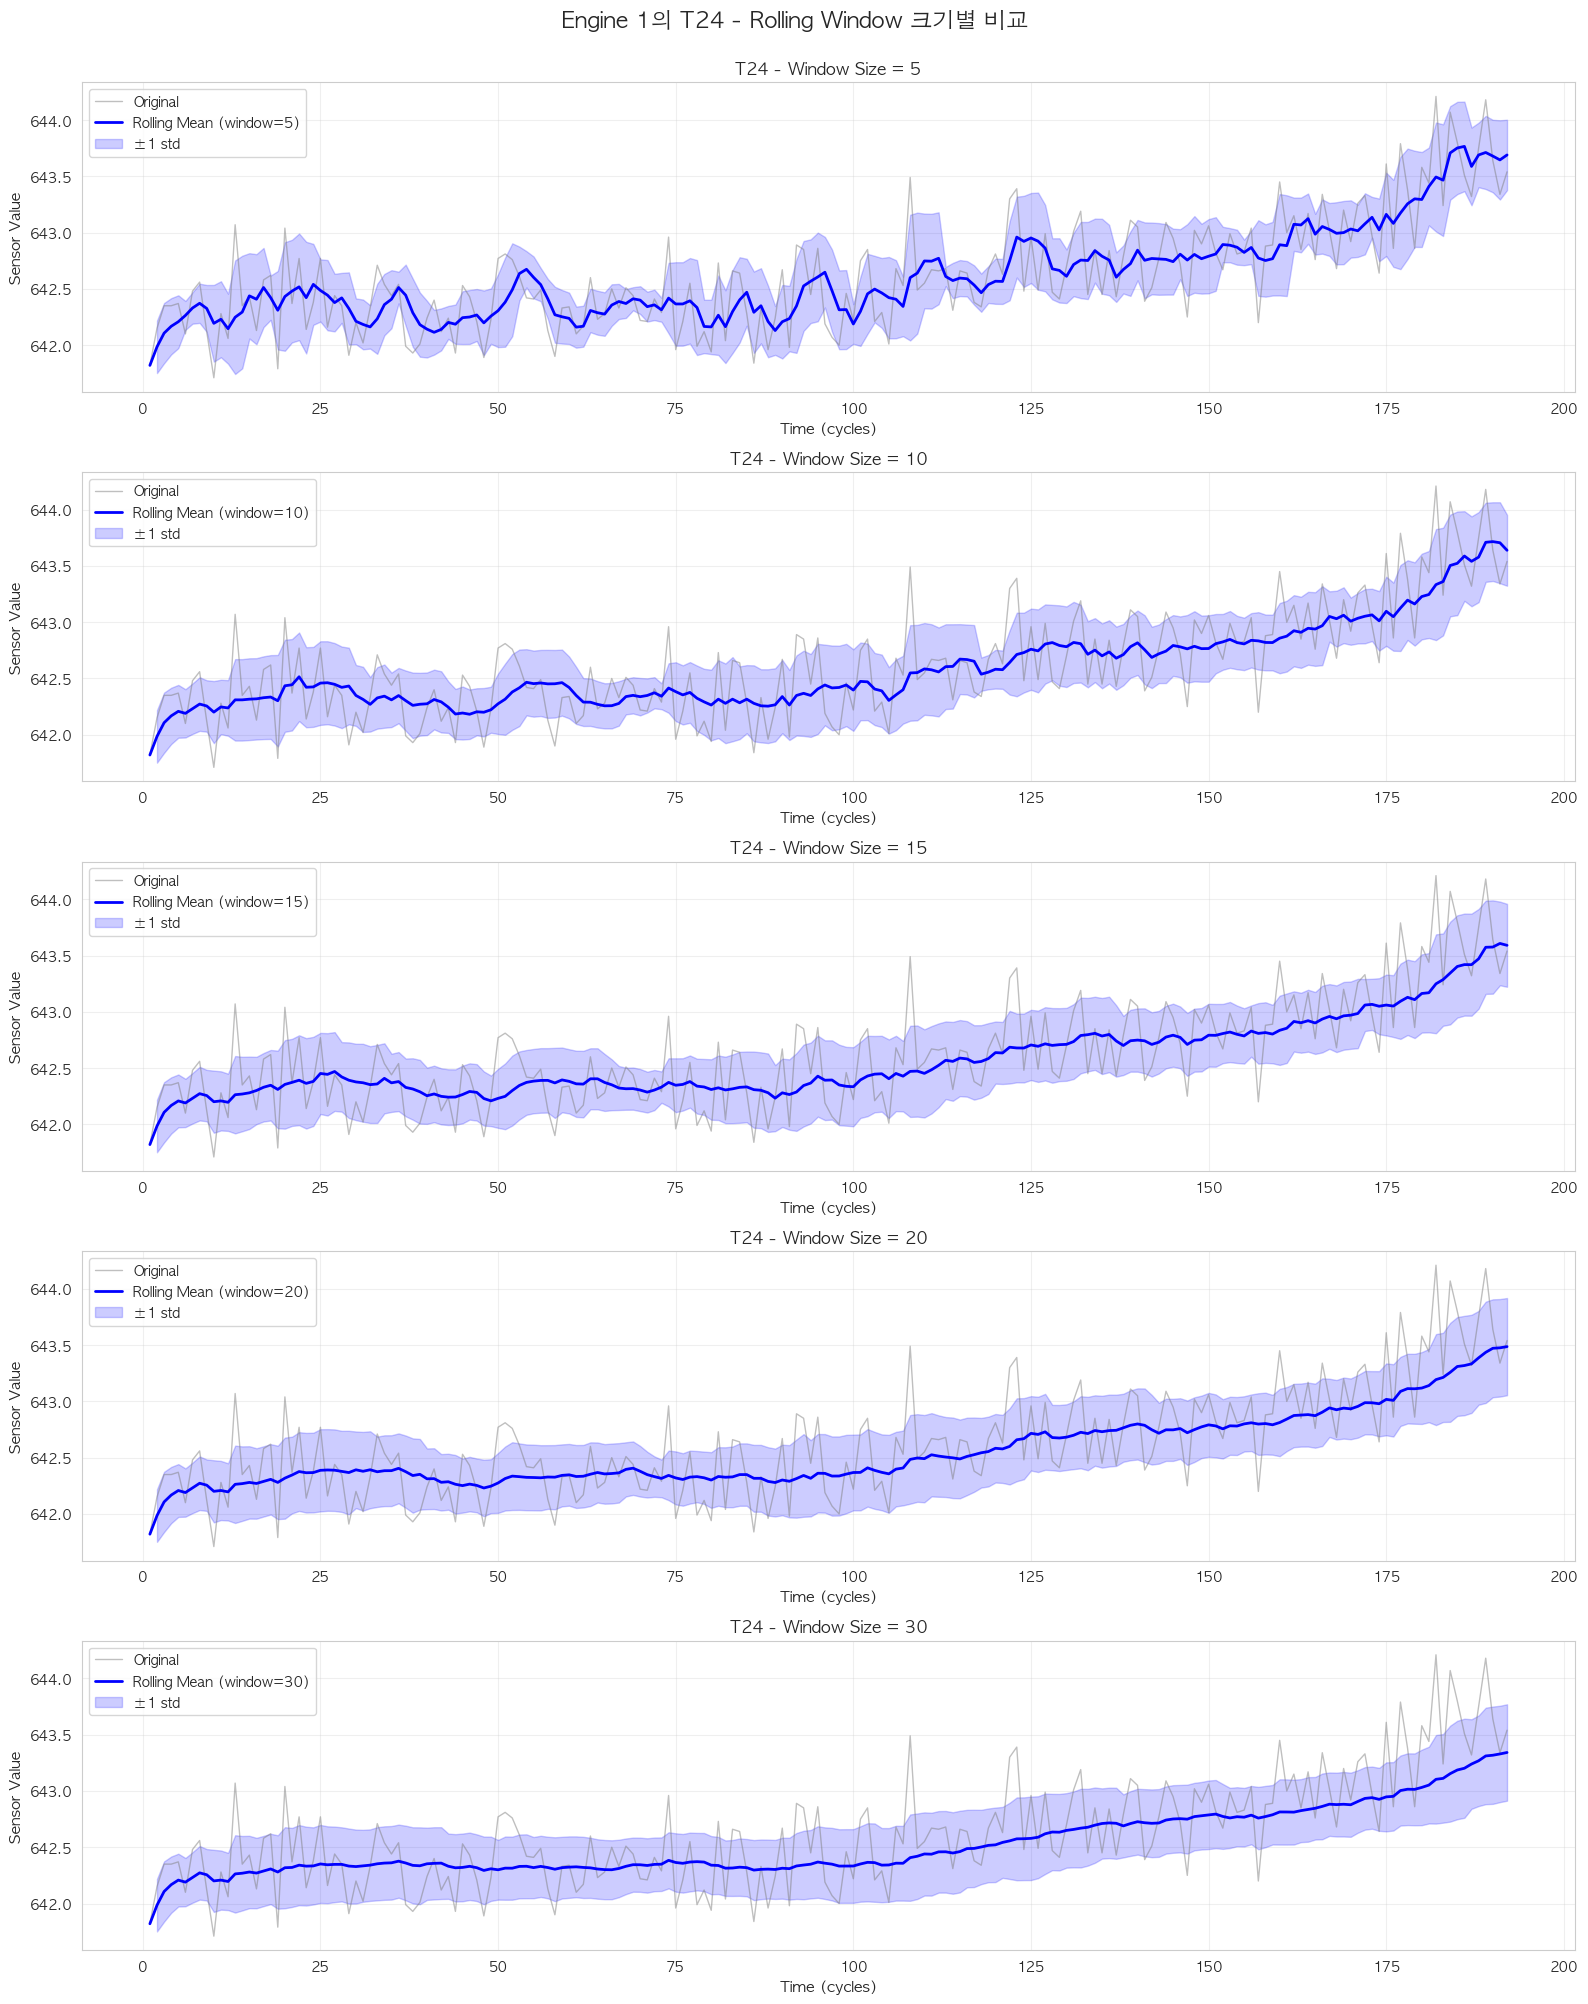

In [109]:
# 샘플 엔진으로 Window 크기별 효과 시각화
sample_unit_data = train_df[train_df['unit_id'] == 1].copy()

fig, axes = plt.subplots(len(window_sizes), 1, figsize=(16, 4*len(window_sizes)))

for idx, window in enumerate(window_sizes):
    # Rolling mean 계산
    rolling_mean = sample_unit_data[sample_sensor].rolling(window=window, min_periods=1).mean()
    rolling_std = sample_unit_data[sample_sensor].rolling(window=window, min_periods=1).std()
    
    # 시각화
    axes[idx].plot(sample_unit_data['time_cycles'], sample_unit_data[sample_sensor], 
                   label='Original', alpha=0.5, linewidth=1, color='gray')
    axes[idx].plot(sample_unit_data['time_cycles'], rolling_mean, 
                   label=f'Rolling Mean (window={window})', linewidth=2, color='blue')
    axes[idx].fill_between(sample_unit_data['time_cycles'], 
                           rolling_mean - rolling_std, 
                           rolling_mean + rolling_std, 
                           alpha=0.2, color='blue', label='±1 std')
    
    axes[idx].set_xlabel('Time (cycles)', fontsize=11)
    axes[idx].set_ylabel('Sensor Value', fontsize=11)
    axes[idx].set_title(f'{sample_sensor} - Window Size = {window}', 
                        fontsize=12, fontweight='bold')
    axes[idx].legend(loc='best')
    axes[idx].grid(alpha=0.3)

plt.suptitle(f'Engine 1의 {sample_sensor} - Rolling Window 크기별 비교', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [110]:

for window in window_sizes:
    # 각 엔진에서 window 크기보다 작은 데이터 포인트 비율
    total_points = len(train_df)
    lost_info_points = len(train_df[train_df.groupby('unit_id')['time_cycles'].transform('count') < window])
    
    # 평균 사이클 대비 비율
    avg_cycles = train_max_cycles['max_cycles'].mean()
    window_pct = (window / avg_cycles) * 100
    
    print(f"\nWindow Size: {window}")
    print(f"  - 평균 수명 대비 비율: {window_pct:.2f}%")
    print(f"  - 초기 {window} 사이클의 정보 손실: {window} cycles")
    print(f"  - 전체 데이터 중 완전한 통계 불가 비율: {(lost_info_points/total_points)*100:.2f}%")




Window Size: 5
  - 평균 수명 대비 비율: 2.42%
  - 초기 5 사이클의 정보 손실: 5 cycles
  - 전체 데이터 중 완전한 통계 불가 비율: 0.00%

Window Size: 10
  - 평균 수명 대비 비율: 4.85%
  - 초기 10 사이클의 정보 손실: 10 cycles
  - 전체 데이터 중 완전한 통계 불가 비율: 0.00%

Window Size: 15
  - 평균 수명 대비 비율: 7.27%
  - 초기 15 사이클의 정보 손실: 15 cycles
  - 전체 데이터 중 완전한 통계 불가 비율: 0.00%

Window Size: 20
  - 평균 수명 대비 비율: 9.69%
  - 초기 20 사이클의 정보 손실: 20 cycles
  - 전체 데이터 중 완전한 통계 불가 비율: 0.00%

Window Size: 30
  - 평균 수명 대비 비율: 14.54%
  - 초기 30 사이클의 정보 손실: 30 cycles
  - 전체 데이터 중 완전한 통계 불가 비율: 0.00%


In [ ]:
# EDA 결과 저장 (추후 모델링에 활용)
eda_results = {
    'sensors_to_remove': sensors_to_remove,
    'sensors_to_keep': sensors_to_keep,
    'recommended_window_size': 15,
    'dataset_info': {
        'train_engines': train_df['unit_id'].nunique(),
        'test_engines': test_df['unit_id'].nunique(),
        'avg_lifetime': train_max_cycles['max_cycles'].mean(),
        'total_features': len(column_names)
    }
}


for key, value in eda_results.items():
    print(f"\n{key}:")
    print(f"  {value}")
    

EDA 결과 저장 완료

sensors_to_remove:
  ['Nf_dmd', 'P15', 'P2', 'PCNfR_dmd', 'T2', 'epr', 'farB']

sensors_to_keep:
  ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']

recommended_window_size:
  15

dataset_info:
  {'train_engines': 100, 'test_engines': 100, 'avg_lifetime': 206.31, 'total_features': 26}

✅ EDA 완료! 다음 단계로 Feature Engineering을 진행하세요.
